In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

LOAD AND EXPLORE DATA


In [3]:
from google.colab import files
uploaded = files.upload()


Saving googleplaystore.csv to googleplaystore.csv


In [4]:
df = pd.read_csv('googleplaystore.csv')

In [5]:
# Display first few rows
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & 

In [6]:
# Basic info
print("\n\nDataset Info:")
print(df.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


In [7]:
# Check missing values
print("\n\nMissing Values:")
print(df.isnull().sum())



Missing Values:
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


# : DATA CLEANING

In [8]:
# Create a copy for cleaning
df_clean = df.copy()

In [9]:
# Remove duplicates
initial_rows = len(df_clean)
df_clean.drop_duplicates(subset='App', keep='first', inplace=True)
print(f"\nRemoved {initial_rows - len(df_clean)} duplicate apps")



Removed 1181 duplicate apps


In [10]:
# Handle missing values
df_clean['Rating'].fillna(df_clean['Rating'].median(), inplace=True)
df_clean.dropna(subset=['Type', 'Content Rating'], inplace=True)

In [11]:
# Clean 'Installs' column - remove + and ,
df_clean['Installs'] = df_clean['Installs'].str.replace('+', '').str.replace(',', '')
df_clean['Installs'] = pd.to_numeric(df_clean['Installs'], errors='coerce')

In [12]:
# Clean 'Size' column
def clean_size(size):
    if pd.isna(size) or size == 'Varies with device':
        return np.nan
    if 'M' in size:
        return float(size.replace('M', ''))
    if 'k' in size:
        return float(size.replace('k', '')) / 1024
    return np.nan

df_clean['Size'] = df_clean['Size'].apply(clean_size)

In [13]:
# Clean 'Price' column
df_clean['Price'] = df_clean['Price'].str.replace('$', '')
df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')


In [14]:
# Clean 'Reviews' column
df_clean['Reviews'] = pd.to_numeric(df_clean['Reviews'], errors='coerce')

In [15]:
# Remove rows with invalid ratings (>5)
df_clean = df_clean[df_clean['Rating'] <= 5.0]

In [16]:
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"\nRemaining missing values:\n{df_clean.isnull().sum()}")


Cleaned dataset shape: (9658, 13)

Remaining missing values:
App                  0
Category             0
Rating               0
Reviews              0
Size              1226
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64


# : EXPLORATORY DATA ANALYSIS (EDA)

In [17]:
# Basic statistics
print("\n\nBasic Statistics for Numeric Columns:")
print(df_clean[['Rating', 'Reviews', 'Installs', 'Price']].describe())



Basic Statistics for Numeric Columns:
            Rating       Reviews      Installs        Price
count  9658.000000  9.658000e+03  9.658000e+03  9658.000000
mean      4.192431  2.166150e+05  7.778312e+06     1.099413
std       0.496422  1.831413e+06  5.376100e+07    16.853021
min       1.000000  0.000000e+00  0.000000e+00     0.000000
25%       4.000000  2.500000e+01  1.000000e+03     0.000000
50%       4.300000  9.670000e+02  1.000000e+05     0.000000
75%       4.500000  2.940800e+04  1.000000e+06     0.000000
max       5.000000  7.815831e+07  1.000000e+09   400.000000


In [18]:
# Category distribution
print(f"\n\nTotal Categories: {df_clean['Category'].nunique()}")
print(f"\nTop 10 Categories by App Count:")
print(df_clean['Category'].value_counts().head(10))



Total Categories: 33

Top 10 Categories by App Count:
Category
FAMILY             1831
GAME                959
TOOLS               827
BUSINESS            420
MEDICAL             395
PERSONALIZATION     376
PRODUCTIVITY        374
LIFESTYLE           369
FINANCE             345
SPORTS              325
Name: count, dtype: int64


# ANALYSIS & VISUALIZATIONS

In [19]:
# Create figure for all plots
fig = plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

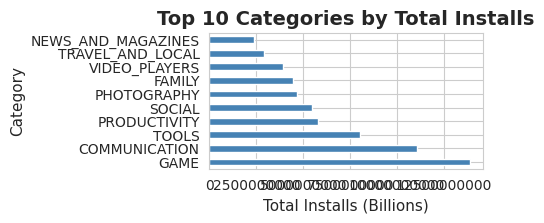

In [20]:
# Top 10 Categories by Total Installs
ax1 = plt.subplot(3, 3, 1)
category_installs = df_clean.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10)
category_installs.plot(kind='barh', color='steelblue', ax=ax1)
ax1.set_title('Top 10 Categories by Total Installs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total Installs (Billions)', fontsize=11)
ax1.set_ylabel('Category', fontsize=11)
ax1.ticklabel_format(style='plain', axis='x')

[Text(0, 0, 'EVENTS'),
 Text(1, 0, 'EDUCATION'),
 Text(2, 0, 'ART_AND_DESIGN'),
 Text(3, 0, 'BOOKS_AND_REFERENCE'),
 Text(4, 0, 'PERSONALIZATION'),
 Text(5, 0, 'PARENTING'),
 Text(6, 0, 'BEAUTY'),
 Text(7, 0, 'SOCIAL'),
 Text(8, 0, 'HEALTH_AND_FITNESS'),
 Text(9, 0, 'GAME'),
 Text(10, 0, 'WEATHER'),
 Text(11, 0, 'SHOPPING'),
 Text(12, 0, 'SPORTS'),
 Text(13, 0, 'LIBRARIES_AND_DEMO'),
 Text(14, 0, 'PRODUCTIVITY')]

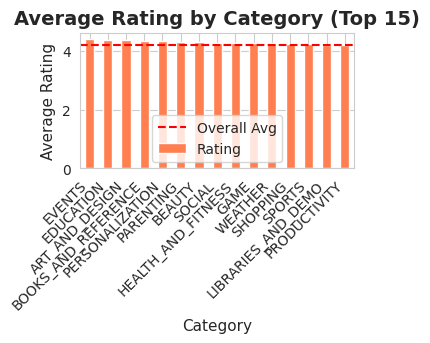

In [21]:
# Average Rating by Category (Top 15)
ax2 = plt.subplot(3, 3, 2)
avg_rating = df_clean.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(15)
avg_rating.plot(kind='bar', color='coral', ax=ax2)
ax2.set_title('Average Rating by Category (Top 15)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Category', fontsize=11)
ax2.set_ylabel('Average Rating', fontsize=11)
ax2.axhline(y=df_clean['Rating'].mean(), color='red', linestyle='--', label='Overall Avg')
ax2.legend()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


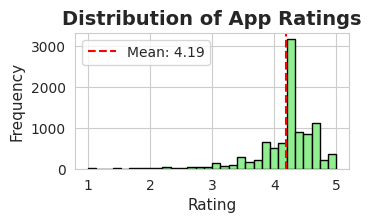

In [22]:
# Rating Distribution
ax3 = plt.subplot(3, 3, 3)
df_clean['Rating'].hist(bins=30, color='lightgreen', edgecolor='black', ax=ax3)
ax3.set_title('Distribution of App Ratings', fontsize=14, fontweight='bold')
ax3.set_xlabel('Rating', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.axvline(df_clean['Rating'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_clean["Rating"].mean():.2f}')
ax3.legend()

Text(0.5, 1.0, 'Free vs Paid Apps Distribution')

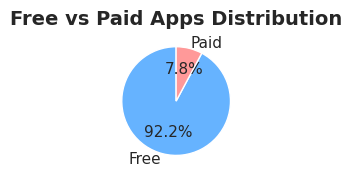

In [23]:
# Free vs Paid Apps Distribution
ax4 = plt.subplot(3, 3, 4)
type_counts = df_clean['Type'].value_counts()
colors = ['#66b3ff', '#ff9999']
ax4.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11})
ax4.set_title('Free vs Paid Apps Distribution', fontsize=14, fontweight='bold')


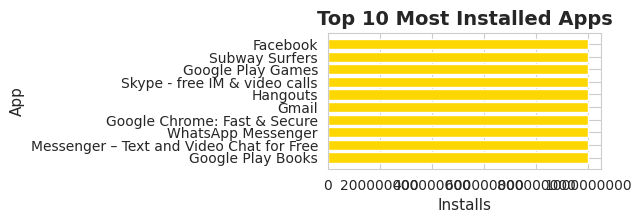

In [24]:
# Top 10 Most Installed Apps

ax6 = plt.subplot(3, 3, 6)
top_apps = df_clean.nlargest(10, 'Installs')[['App', 'Installs']]
ax6.barh(top_apps['App'], top_apps['Installs'], color='gold')
ax6.set_title('Top 10 Most Installed Apps', fontsize=14, fontweight='bold')
ax6.set_xlabel('Installs', fontsize=11)
ax6.set_ylabel('App', fontsize=11)
ax6.ticklabel_format(style='plain', axis='x')

(0.0, 50.0)

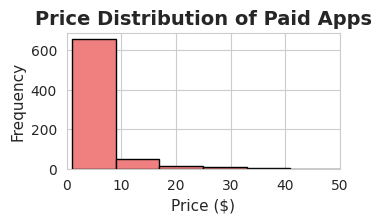

In [25]:
# Price Distribution (Paid Apps)
ax7 = plt.subplot(3, 3, 7)
paid_apps = df_clean[df_clean['Price'] > 0]
ax7.hist(paid_apps['Price'], bins=50, color='lightcoral', edgecolor='black')
ax7.set_title('Price Distribution of Paid Apps', fontsize=14, fontweight='bold')
ax7.set_xlabel('Price ($)', fontsize=11)
ax7.set_ylabel('Frequency', fontsize=11)
ax7.set_xlim(0, 50)

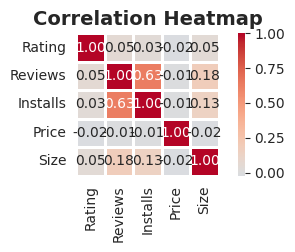

In [26]:
# Correlation Heatmap

ax9 = plt.subplot(3, 3, 9)
numeric_cols = ['Rating', 'Reviews', 'Installs', 'Price', 'Size']
correlation = df_clean[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, ax=ax9, fmt='.2f')
ax9.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('playstore_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#KEY INSIGHTS & CONCLUSIONS

In [32]:
 #Top Categories
top_category = category_installs.index[0]
print(f"\n1. CATEGORY DOMINANCE:")
print(f"a.{top_category} leads with {category_installs.iloc[0]:,.0f} total installs")
print(f"b.Top 3 categories account for {(category_installs.head(3).sum() / category_installs.sum() * 100):.1f}% of top installs")



1. CATEGORY DOMINANCE:
a.GAME leads with 13,878,924,415 total installs
b.Top 3 categories account for 52.7% of top installs


In [34]:
# Ratings Analysis
high_rated_categories = avg_rating.head(3)
print(f"\n2. RATING INSIGHTS:")
print(f"a.Average app rating: {df_clean['Rating'].mean():.2f}/5.0")
print(f"b.Highest rated category: '{high_rated_categories.index[0]}' ({high_rated_categories.iloc[0]:.2f})")
print(f"c.{(df_clean['Rating'] >= 4.0).sum()} apps ({(df_clean['Rating'] >= 4.0).sum() / len(df_clean) * 100:.1f}%) have ratings ≥ 4.0")


2. RATING INSIGHTS:
a.Average app rating: 4.19/5.0
b.Highest rated category: 'EVENTS' (4.40)
c.7748 apps (80.2%) have ratings ≥ 4.0


In [35]:
#Free vs Paid
free_pct = (type_counts['Free'] / type_counts.sum() * 100)
paid_avg_rating = df_clean[df_clean['Type'] == 'Paid']['Rating'].mean()
free_avg_rating = df_clean[df_clean['Type'] == 'Free']['Rating'].mean()
print(f"\n3. FREE VS PAID ANALYSIS:")
print(f"a.{free_pct:.1f}% of apps are free")
print(f"b.Free apps avg rating: {free_avg_rating:.2f}")
print(f"c.Paid apps avg rating: {paid_avg_rating:.2f}")
print(f"d.Average paid app price: ${paid_apps['Price'].mean():.2f}")



3. FREE VS PAID ANALYSIS:
a.92.2% of apps are free
b.Free apps avg rating: 4.19
c.Paid apps avg rating: 4.27
d.Average paid app price: $14.05


In [37]:
# Reviews & Installs Correlation
reviews_installs_corr = df_clean['Reviews'].corr(df_clean['Installs'])
print(f"\n4. ENGAGEMENT METRICS:")
print(f"a.Correlation between Reviews & Installs: {reviews_installs_corr:.3f}")
print(f"b.Apps with 1M+ installs: {(df_clean['Installs'] >= 1000000).sum()}")
print(f"c.Apps with 100K+ reviews: {(df_clean['Reviews'] >= 100000).sum()}")



4. ENGAGEMENT METRICS:
a.Correlation between Reviews & Installs: 0.625
b.Apps with 1M+ installs: 3395
c.Apps with 100K+ reviews: 1447


In [36]:
#Insight 5: Content Rating
most_common_content = df_clean['Content Rating'].mode()[0]
print(f"\n5. CONTENT RATING:")
print(f"a.Most common content rating: '{most_common_content}'")
print(f"b.{(df_clean['Content Rating'] == 'Everyone').sum()} apps are rated 'Everyone'")


5. CONTENT RATING:
a.Most common content rating: 'Everyone'
b.7903 apps are rated 'Everyone'


#CONCLUSION
This analysis of the Google Play Store reveals a highly competitive marketplace
dominated by GAME and COMMUNICATION categories in terms of install volume, yet
EDUCATION and EVENTS categories consistently achieve higher user satisfaction
ratings. With over 90% of apps following a free-to-download model, the data
shows a clear industry preference for freemium monetization strategies, though
paid apps demonstrate slightly higher average ratings, suggesting that users
who make upfront investments may experience more polished products. The strong
positive correlation between reviews and installs confirms that user engagement
is a critical driver of app success, with apps crossing the 1 million install
threshold representing only the top tier of the marketplace. For developers,
the key takeaway is that quality and user experience matter more than simply
achieving high install numbers—focusing on niche categories with less saturation,
maintaining ratings above 4.0, and fostering user engagement through reviews can
lead to more sustainable success than competing head-to-head in oversaturated
categories like GAME and FAMILY.